# Cuaderno 22: Modelo con restricciones de corte para el ATSP

$\newcommand{\card}[1]{\left| #1 \right|}$
$\newcommand{\tabulatedset}[1]{\left\{ #1 \right\}}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$

Recordar que, dados: 
* un grafo dirigido **completo** $D=(V,A)$; y,
* un vector $c \in \ZZ^{A}$ de costos asociados a los arcos de $D$;

el *problema del agente viajero asimétrico (Asymmetric Traveling Salesman Problem, ATSP)* consiste en encontrar un circuito que visite **todos** los nodos de $D$ y que tenga el menor costo posible.

En el Cuaderno 21 revisamos un modelo de programación lineal entera para este problema. Un aspecto importante a considerar en el modelo fueron las restricciones de eliminación de subtoures, las cuales consisitían en requerir que, para cualquier subconjunto de nodos $W \subset V$, con $\emptyset \neq W \neq V$, el número de arcos seleccionados en la solución que tengan sus dos extremos dentro de $W$ sea menor o igual a $\card{W} - 1$.

Una manera alternativa de eliminar subciclos consiste en requerir que la solución contenga siempre un arco del corte entrante $\delta^{-}(W)$ o un arco del corte saliente $\delta^{+}(W)$ para cada $W \subset V$ con $\emptyset \neq W \neq V$. Estas restricciones se conocen como *restricciones de corte*. Los conjuntos de corte están definidos por:

\begin{align*}
\delta^{-}(W) &:= \{ (i,j) \in A \, : \, i \not\in W, j \in W\}, \\
\delta^{+}(W) &:= \{ (i,j) \in A \, : \, i \in W, j \not\in W\}. \\
\end{align*}


De esta manera, el problema del agente viajero asimétrico puede formularse como el siguiente programa lineal entero:

\begin{align*} 
\min &\sum_{(i,j) \in A} c_{ij} x_{ij}\\ 
& \mbox{s.r.}\\
&\sum_{(j, i) \in A} x_{ji} = 1, \quad \forall i \in V,\\
&\sum_{(i, j) \in A} x_{ij} = 1, \quad \forall i \in V,\\ 
&\sum_{(i,j) \in \delta^{-}(W)} x_{ij} \geq 1, \quad \forall W \subset V, \emptyset \neq W \neq V,\\
& x_{ij} \in \{0, 1\}, \quad \forall (i, j) \in A.
\end{align*}

Vamos a implementar este modelo usando la interfaz Python de Gurobi.



Definimos primero los datos. Usaremos la función `randint` para generar puntos con coordenadas aleatorias en el rango {0,..,100}. El costo de un arco $(i,j)$ será igual a la distancia euclideana entre $i$ y $j$:

In [1]:
from gurobipy import *
import random as rm
import math 

# Numero de nodos del grafo
n = 10

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
 
A = c.keys()


Vamos a necesitar construir una restricción de corte para cada subconjunto de nodos $W \subset V$ tal que $\emptyset \neq W \neq V$. Con esta finalidad, definimos una función `powerset` empleando las funciones `chain` y `combinations` del módulo `itertools`.

In [2]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


Definimos ahora el objeto modelo, las variables y la función objetivo:

In [3]:
# Crear el objeto modelo
m = Model('atsp-corte')

# Crear las variables
x = m.addVars(A, name="x", vtype=GRB.BINARY)

# Crear la funcion objetivo
m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)


Using license file /Users/ltorres/gurobi.lic
Academic license - for non-commercial use only


Añadimos las restricciones de grado:

In [4]:
# Restricciones de grado saliente
m.addConstrs((x.sum(i,'*')  == 1 for i in V), 
                 "g_saliente")
    
# Restricciones de grado entrante
m.addConstrs((x.sum('*', i)  == 1 for i in V), 
                 "g_entrante")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>}

Para construir las restricciones de corte, usamos la función `powerset` para iterar sobre todos los subconjuntos de vértices $W$ tales que $\emptyset \neq W \neq V$. Para cada subconjunto, determinamos su complemento $W_c:= V \setminus W$. La expresión `x.sum(Wc, W)` construye la suma de las variables asociadas a arcos del corte entrante de $W$.

In [5]:
# Restricciones de corte para eliminar subtoures
for W in powerset(V):
    if W!=() and W!=tuple(V):
        Wc = [i for i in V if i not in W]
        m.addConstr(x.sum(Wc, W) >= 1, "subciclo[{}]".format(W))


Escribimos el modelo a un archivo de texto:

In [6]:
# Escribir el modelo a un archivo
m.write('atsp.lp')


Finalmente, resolvemos el modelo y mostramos la solución:

In [7]:
# Calcular la solucion optima
m.optimize()

# Escribir la solucion
if m.status == GRB.Status.OPTIMAL:
    # Recuperar los valores de las variables
    vx = m.getAttr('x', x)
    print('\nTour optimo:')
    for i,j in A:
        if vx[i,j] >= 0.99:
            print('{} -> {}'.format(i, j))


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 1042 rows, 90 columns and 23220 nonzeros
Model fingerprint: 0xebae7d76
Variable types: 0 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 466.3704025
Presolve removed 20 rows and 0 columns
Presolve time: 0.13s
Presolved: 1022 rows, 90 columns, 23040 nonzeros
Variable types: 0 continuous, 90 integer (90 binary)

Root relaxation: objective 2.967912e+02, 36 iterations, 0.06 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     296.7911600  296.79116  0.00%     -    0s

Explored 0 nodes (36 simplex iterations) in 0.55 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 296.791 

Por último, empleamos el módulo `matplotlib` y la función `dibujarTour` del Cuaderno 21 para graficar el tour de la solución.


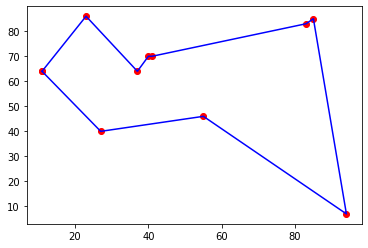

In [8]:
import matplotlib.pyplot as plt
import random

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()
    
# Crear lista con arcos seleccionados en la solucion
L = [(i,j) for i,j in A if vx[i,j]>0]

# Recuperar el tour como un ordenamiento de los nodos
T = [1]
# nodo actual:
i = 1
while True:
    # Determinar sucesor de i
    j = [j for j in V if (i,j) in L].pop()
    # Colocar sucesor en la lista del tour y actualizar i
    T.append(j)
    i = j
    # Terminar cuando el nodo colocado sea 1
    if i==1: break;
        
# Graficar el tour
dibujarTour(coordx, coordy, T)    

## Código completo

Se reproduce a continuación el código completo del modelo anterior.

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 131104 rows, 272 columns and 8913440 nonzeros
Model fingerprint: 0x5f4537f3
Variable types: 0 continuous, 272 integer (272 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 946.4546961
Presolve removed 34 rows and 0 columns (presolve time = 7s) ...
Presolve removed 34 rows and 0 columns (presolve time = 15s) ...
Presolve removed 34 rows and 0 columns (presolve time = 28s) ...
Presolve removed 34 rows and 0 columns (presolve time = 31s) ...
Presolve removed 34 rows and 0 columns
Presolve time: 30.95s
Presolved: 131070 rows, 272 columns, 8912896 nonzeros
Variable types: 0 continuous, 272 integer (272 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   -0.0000000e+00   0.000000e+00   1.310700e+05     35s
     

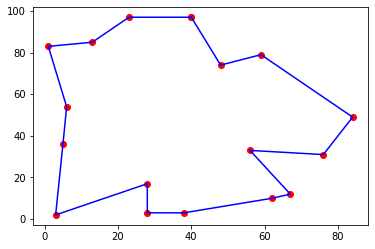

In [10]:
# Implementación de modelos lineales enteros
# Problema del agente viajero asimétrico (TSP)

# Luis M. Torres (EPN 2020)

from gurobipy import *
import random as rm
import matplotlib.pyplot as plt
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

# Numero de nodos del grafo
n = 17

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({
    (i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
    for i in V for j in V if i!=j
})
 
A = c.keys()

try:
    # Crear el objeto modelo
    m = Model('tsp')

    # Crear las variables
    x = m.addVars(A, name="x", vtype=GRB.BINARY)

    # Crear la funcion objetivo
    m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

    # Restricciones de grado saliente
    m.addConstrs((x.sum(i,'*')  == 1 for i in V), 
                 "g_saliente")
    
    # Restricciones de grado entrante
    m.addConstrs((x.sum('*', i)  == 1 for i in V), 
                 "g_entrante")

    # Restricciones de corte para eliminar subtoures
    for W in powerset(V):
        if W!=() and W!=tuple(V):
            Wc = [i for i in V if i not in W]
            m.addConstr(x.sum(Wc, W) >= 1, "subciclo[{}]".format(W))

    # Escribir el modelo a un archivo
    # m.write('tsp.lp')

    # Calcular la solucion optima
    m.optimize()

    # Escribir la solucion
    if m.status == GRB.Status.OPTIMAL:
        # Recuperar los valores de las variables
        vx = m.getAttr('x', x)
        print('\nTour optimo:')
        for i,j in A:
            if vx[i,j] > 0:
                print('{} -> {}'.format(i, j))
                
    # Crear lista con arcos seleccionados en la solucion
    L = [(i,j) for i,j in A if vx[i,j]>0]

    # Recuperar el tour como un ordenamiento de los nodos
    T = [1]
    # nodo actual:
    i = 1
    while True:
        # Determinar sucesor de i
        j = [j for j in V if (i,j) in L].pop()
        # Colocar sucesor en la lista del tour y actualizar i
        T.append(j)
        i = j
        # Terminar cuando el nodo colocado sea 1
        if i==1: break;
        
    # Graficar el tour
    dibujarTour(coordx, coordy, T)    
    
except GurobiError as e:
    print('Se produjo un error de Gurobi: codigo: ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Se produjo un error de atributo')